* [1.Préparation des données](#pd)
* [2.Prétraitement d'une image](#pi)
* [3.Extraction des features avec SIFT](#sift)
* [4.Extraction des features avec Transfer learning](#tl)


In [190]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Traitement images
# Traitement images
import PIL
from PIL import Image, ImageOps, ImageFilter
import cv2
from scipy.ndimage import gaussian_filter


from tensorflow.keras.preprocessing import image
import pickle
#cluster
from sklearn import manifold, decomposition
from sklearn import cluster, metrics

from scipy.spatial import distance

import os

# 1.Préparation des données<a class="anchor" id="pd"></a>

In [99]:
path = 'Flipkart/' # à adapter = répertoire de stockage du dataset
data= pd.read_csv("data_product.csv")
#data

In [42]:
data['image_path'] = data['image'].apply(lambda x:"Flipkart/Images/" +str(x))
data['image_path']

0       Flipkart/Images/55b85ea15a1536d46b7190ad6fff8c...
1       Flipkart/Images/7b72c92c2f6c40268628ec5f14c6d5...
2       Flipkart/Images/64d5d4a258243731dc7bbb1eef49ad...
3       Flipkart/Images/d4684dcdc759dd9cdf41504698d737...
4       Flipkart/Images/6325b6870c54cd47be6ebfbffa620e...
                              ...                        
1045    Flipkart/Images/958f54f4c46b53c8a0a9b8167d9140...
1046    Flipkart/Images/fd6cbcc22efb6b761bd564c2892848...
1047    Flipkart/Images/5912e037d12774bb73a2048f35a000...
1048    Flipkart/Images/c3edc504d1b4f0ba6224fa53a43a7a...
1049    Flipkart/Images/f2f027ad6a6df617c9f125173da71e...
Name: image_path, Length: 1050, dtype: object

In [94]:
df=data[['description','image','image_path','main_category']]
df.head()

description  ...     main_category
0  Key Features of Elegance Polyester Multicolor ...  ...  Home Furnishing 
1  Specifications of Sathiyas Cotton Bath Towel (...  ...        Baby Care 
2  Key Features of Eurospa Cotton Terry Face Towe...  ...        Baby Care 
3  Key Features of SANTOSH ROYAL FASHION Cotton P...  ...  Home Furnishing 
4  Key Features of Jaipur Print Cotton Floral Kin...  ...  Home Furnishing 

[5 rows x 4 columns]

# 2. Prétraitement d'une image <a class="anchor" id="pi"></a>

In [108]:
## fonctions
def afficher_image_histopixel(image, titre):
    '''
    Afficher côte à côte l'image et l'histogramme de répartiton des pixels.
    Parameters
    ----------
    image : image à afficher, obligatoire.
    Returns
    -------
    None.
    '''
    plt.figure(figsize=(40, 10))
    plt.subplot(131)
    plt.title(titre, fontsize=30)
    plt.imshow(image, cmap='gray')
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)

    plt.subplot(132)
    plt.title('Histogramme de répartition des pixels', fontsize=30)
    hist, bins = np.histogram(np.array(image).flatten(), bins=256)
    plt.bar(range(len(hist[0:255])), hist[0:255])
    plt.xlabel('Niveau de gris', fontsize=30)
    plt.ylabel('Nombre de pixels', fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)

    plt.subplot(133)
    plt.title('Histogramme cumulé des pixels', fontsize=30)
    plt.hist(np.array(image).flatten(), bins=range(256), cumulative=True)
    plt.xlabel('Niveau de gris', fontsize=24)
    plt.ylabel('Fréquence cumulée de pixels', fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)

    plt.show()
    
    

def preprocess_image(image):
    '''
     le pré-traitement suivant sera appliqué sur toutes les images :
    - Correction de l'exposition (étirement d'histogramme) avec PILS
      (autocontrast).
    - Correction du contraste (égalisation d'histogramme) avec OpenCV (CLAHE
      (Contrast Limited Adaptive Histogram Equalization).
    - Réduction du bruit avec l'algorithme Non-local Means Denoising d'OpenCV.
    - Conversion en niveau de gris de l'image (ORB, SIFT...).
    - Réduction de dimension avec OpenCV (resize et interpolation INTER_AREA).
    Parameters
    ----------
    image : image localisée dans un répertoire, obligatoire.
    
    Returns
    -------
    None
    '''
    path_out='Flipkart/Images_process/'
    # Variables locales
    dim = (224, 224)

    # Nom de l'image
    file_dir = os.path.split(image)

    # Chargement de l'image originale
    img = Image.open(image)

    # Correction de l'exposition PILS (étirement de l'histogramme)
    img = ImageOps.autocontrast(img, 1)

    # Conversion en niveau de gris de l'image
    img = cv2.cvtColor(np.array(img), cv2.COLOR_B
GR2GRAY)
    # Correction du contraste OpenCV CLAHE (égalisation de l'histogramme)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(3, 3))
    img = clahe.apply(img)

    # Réduction du bruit avec l'algorithme Non-local Means Denoising d'OpenCV
    img = cv2.fastNlMeansDenoising(img, None, 5, 7, 21)

    # Redimensionnement en 224 * 224
    img = cv2.resize(np.array(img), dim, interpolation=cv2.INTER_AREA)

    # Sauvegarde de l'image dans le répertoire Flipkart/Images_process/
    cv2.imwrite(path + file_dir[1], img)

    return (path + file_dir[1])

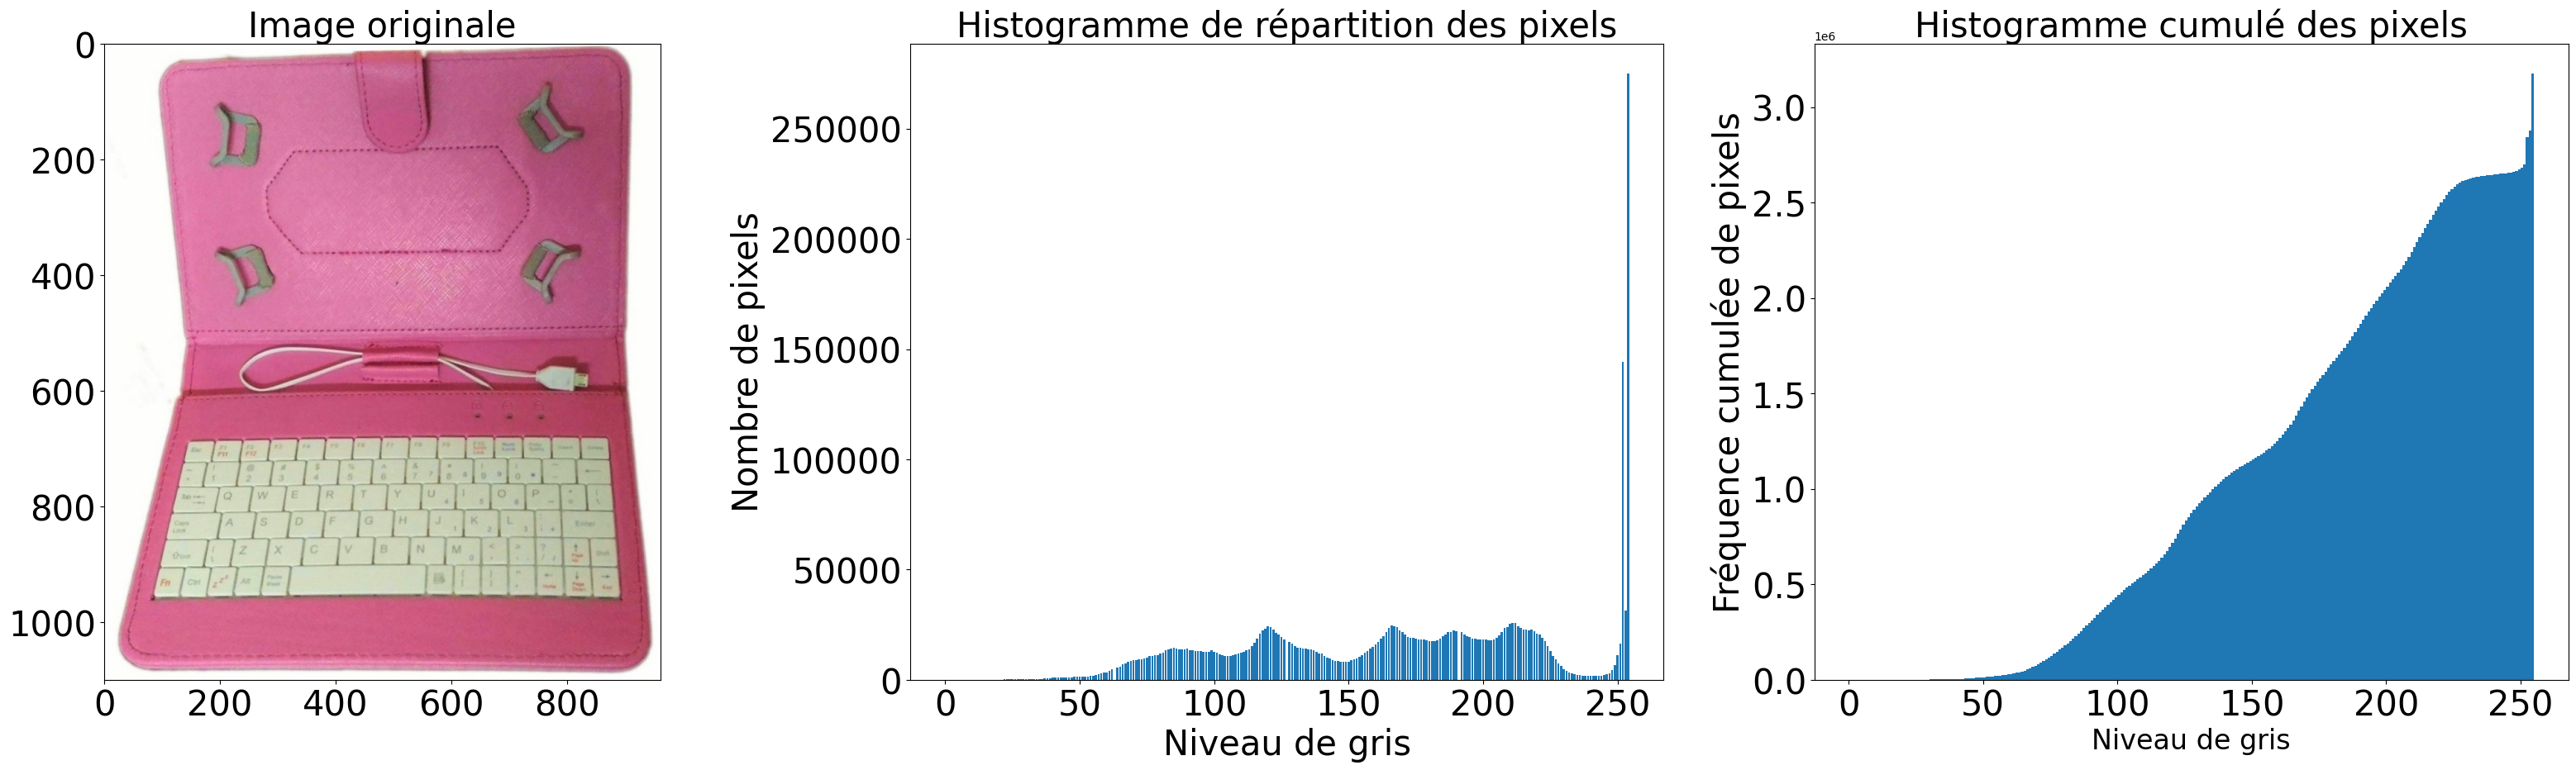

In [105]:
# Chargement de l'image originale comme matrice de pixels
img_orig = Image.open('Flipkart/Images/00e966a5049a262cfc72e6bbf68b80e7.jpg')
afficher_image_histopixel(img_orig, 'Image originale')

<b>Correction de l'exposition( étirement de l'histogramme)
- Corriger de la luminosité (ou exposition) de l'image.
- Image sous-exposée ==> histogramme concentré à droite vers les niveaux de gris faible (255 = blanc).
- Image sur-exposée ==> histogramme concentré à gauche vers les niveaux de gris fort (0 = noir).

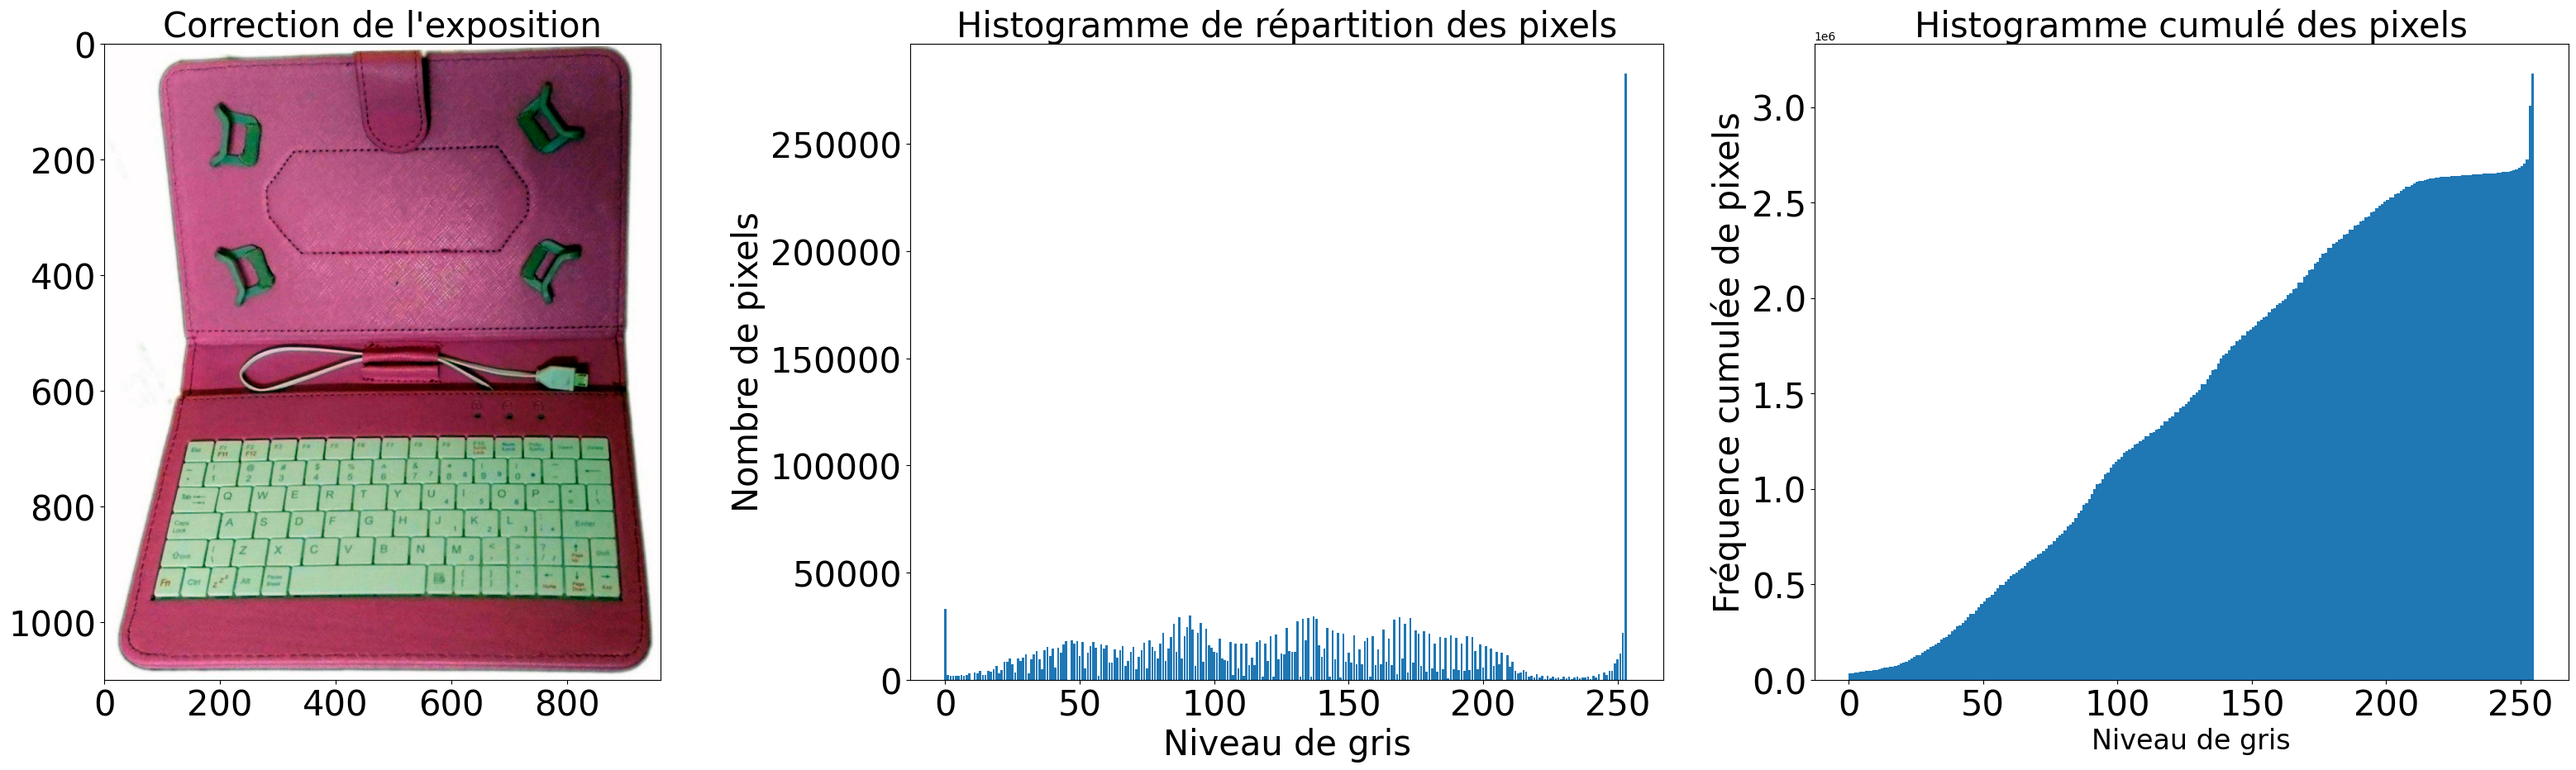

In [106]:
# Correction de l'exposition PILS
img_expo = ImageOps.autocontrast(img_orig, 1)
afficher_image_histopixel(img_expo,'Correction de l\'exposition')

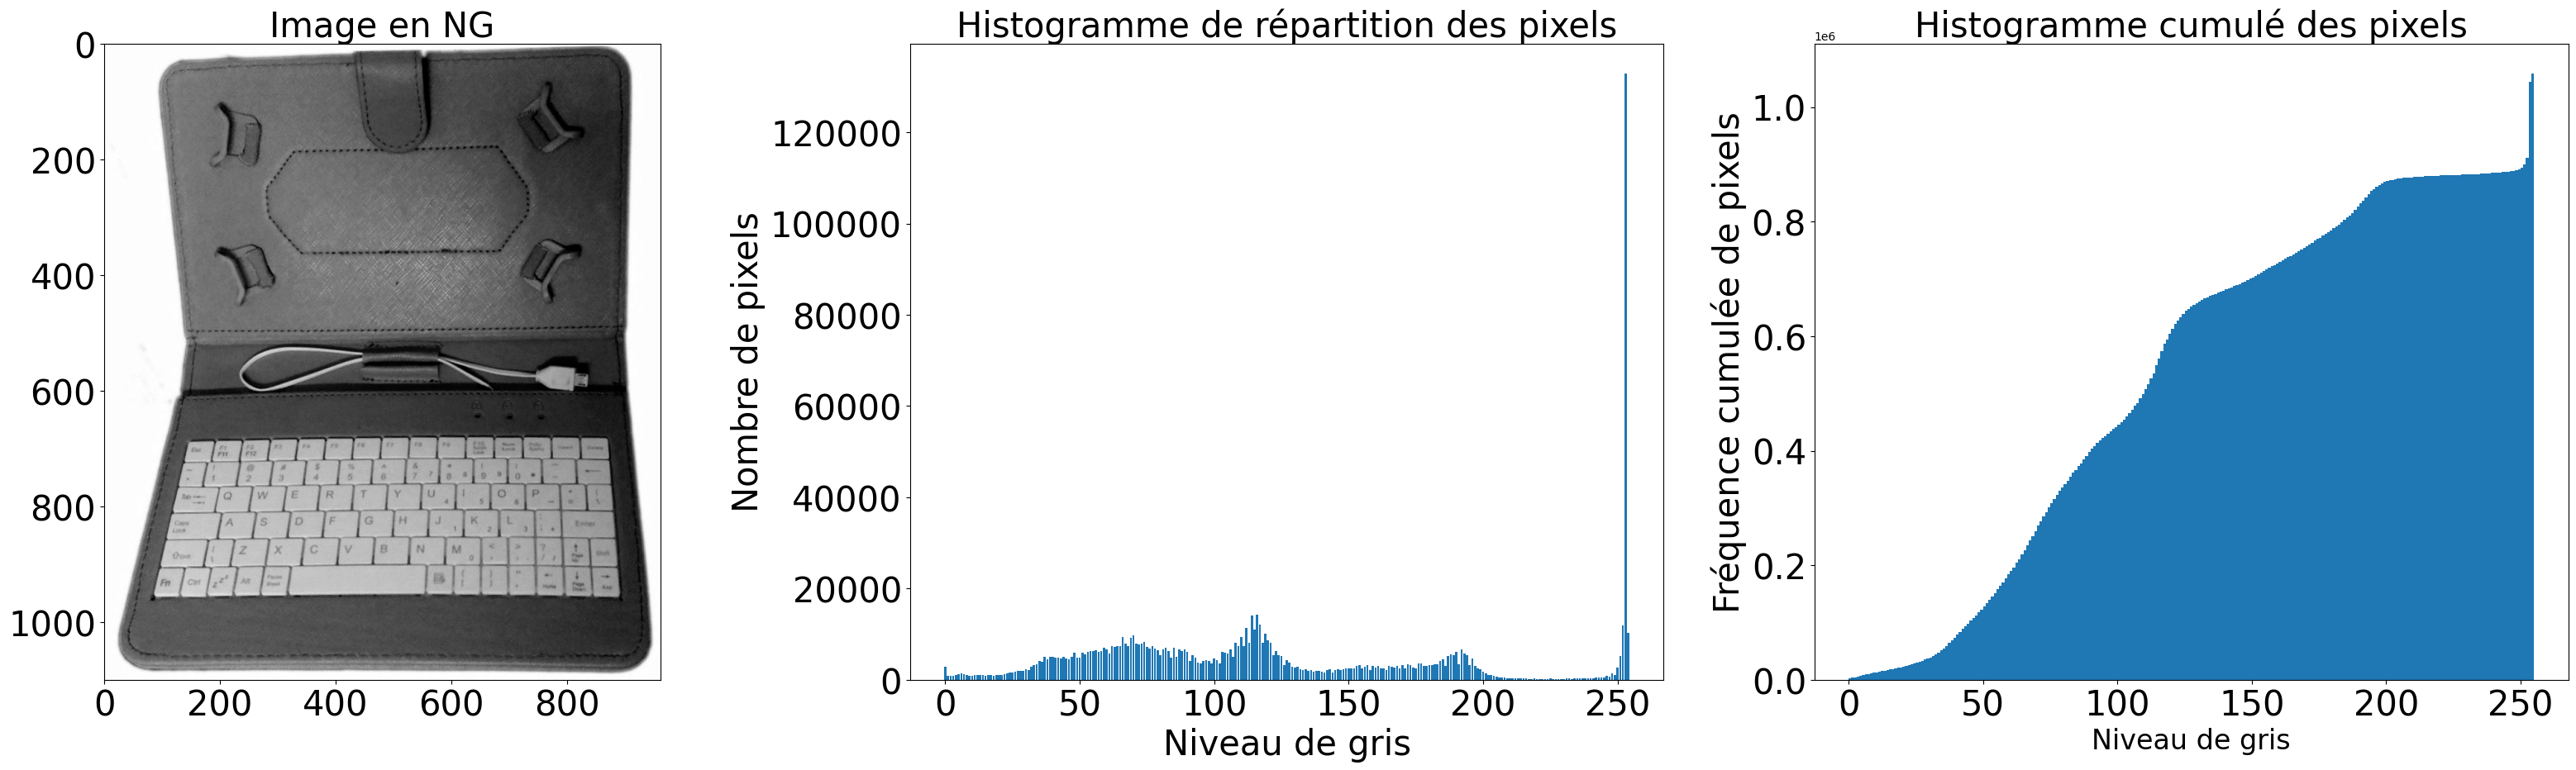

In [215]:
imgNg = cv2.cvtColor(np.array(img_expo), cv2.COLOR_BGR2GRAY)
afficher_image_histopixel(imgNg,'Image en NG')

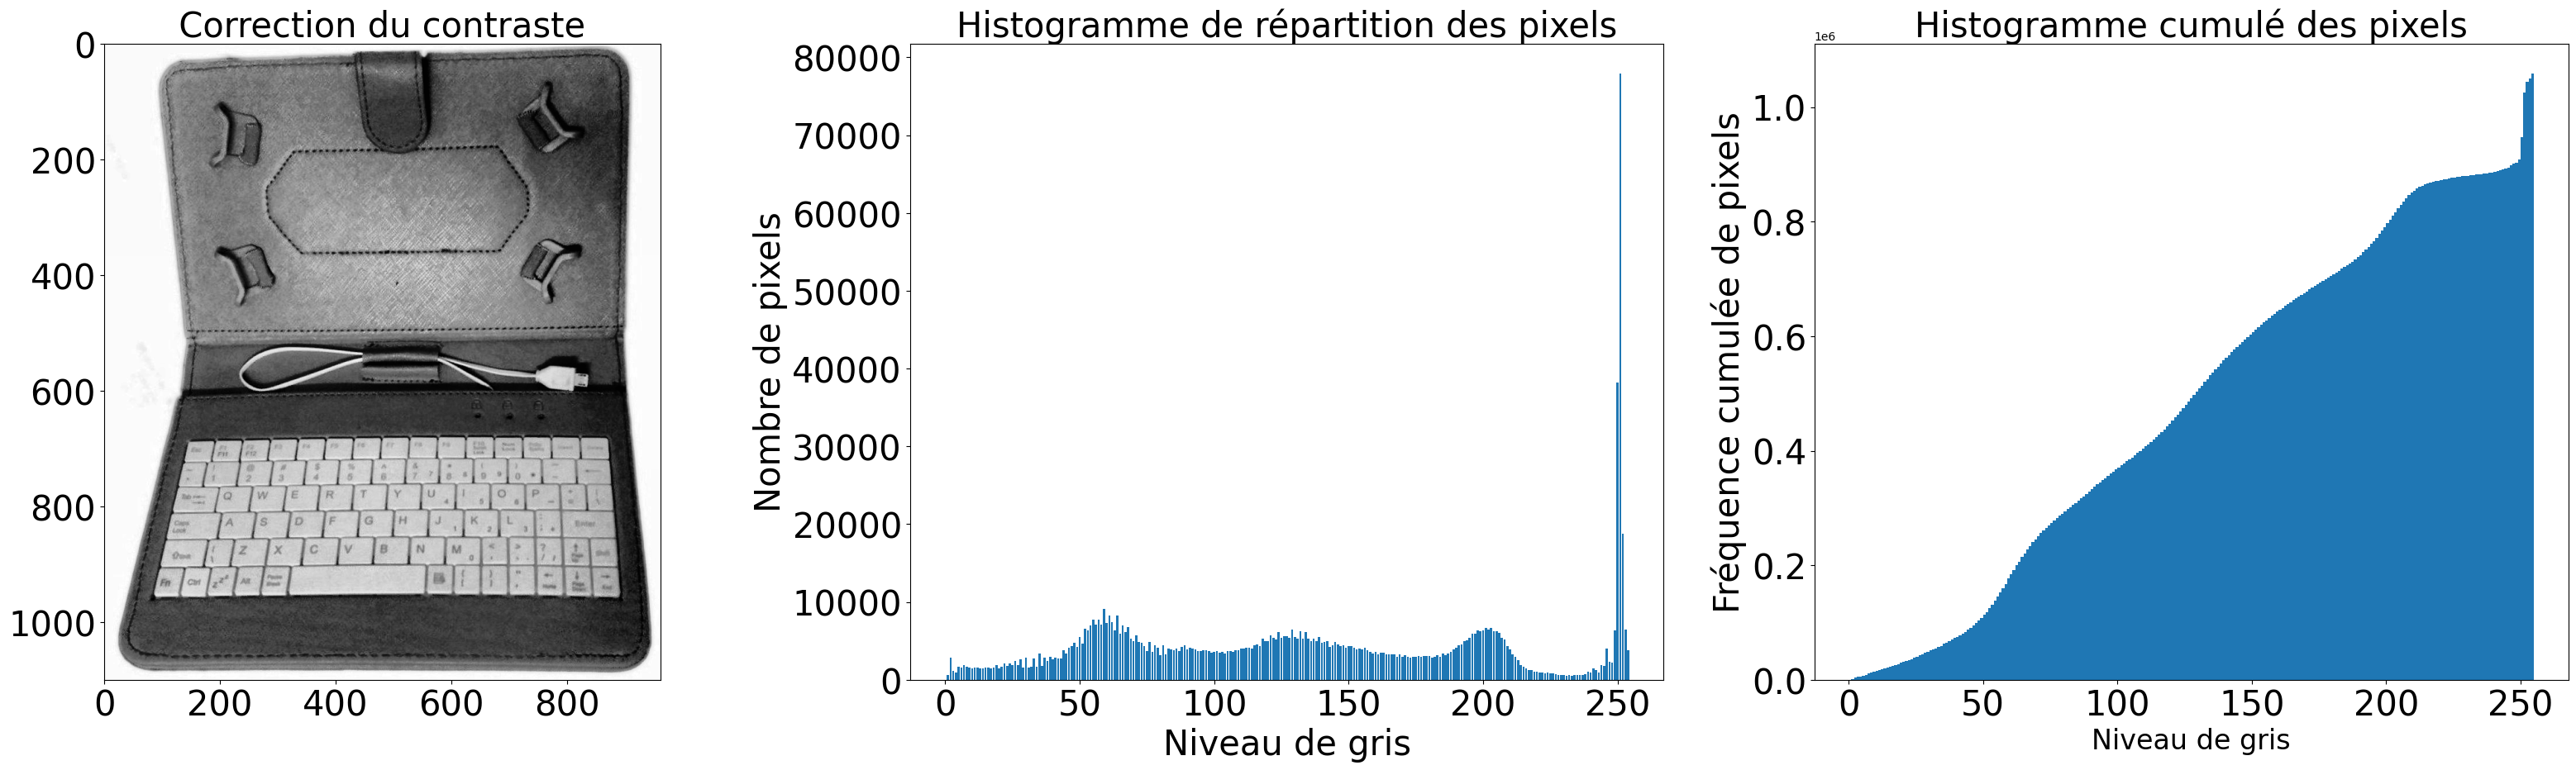

In [217]:
# Correction du contraste OpenCV CLAHE (égalisation de l'histogramme)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(3, 3))
imgco = clahe.apply(imgNg)
afficher_image_histopixel(imgco,' Correction du contraste ')

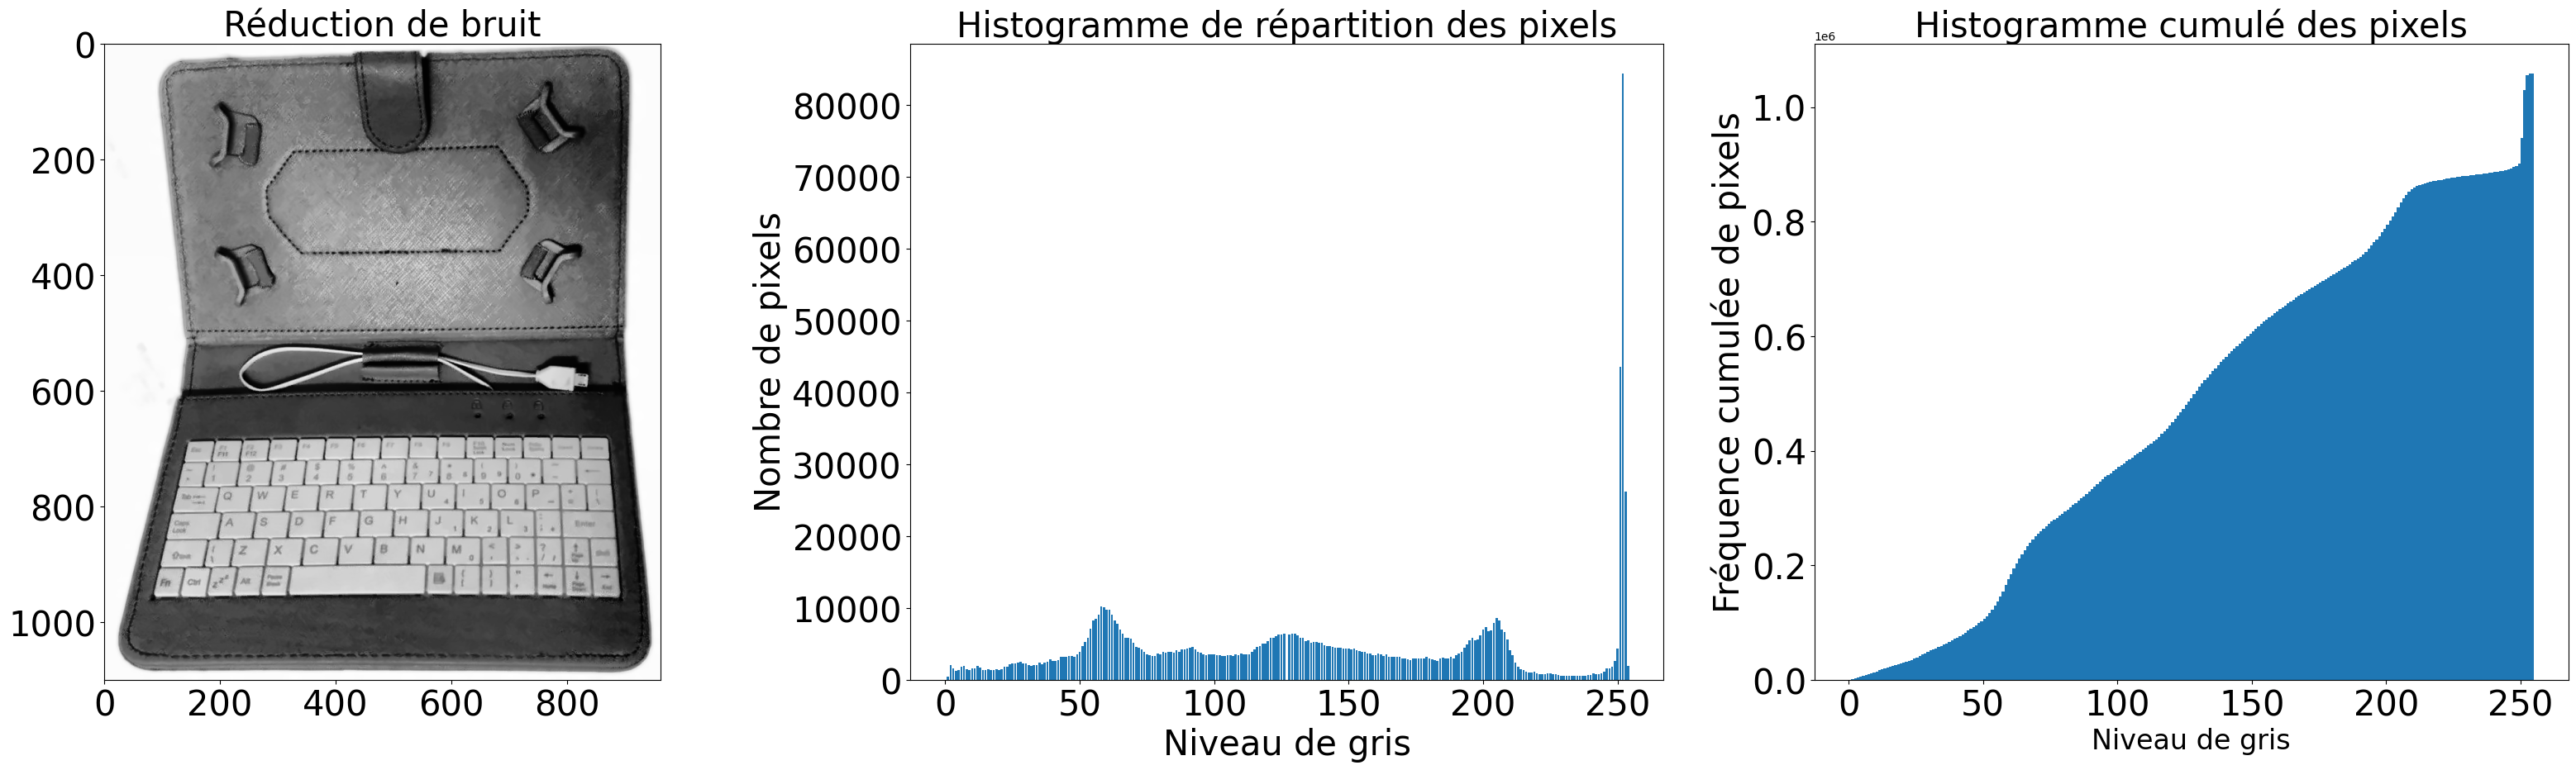

In [219]:
imgden = cv2.fastNlMeansDenoising(imgco, None, 5, 7, 21)
afficher_image_histopixel(imgden,' Réduction de bruit ')

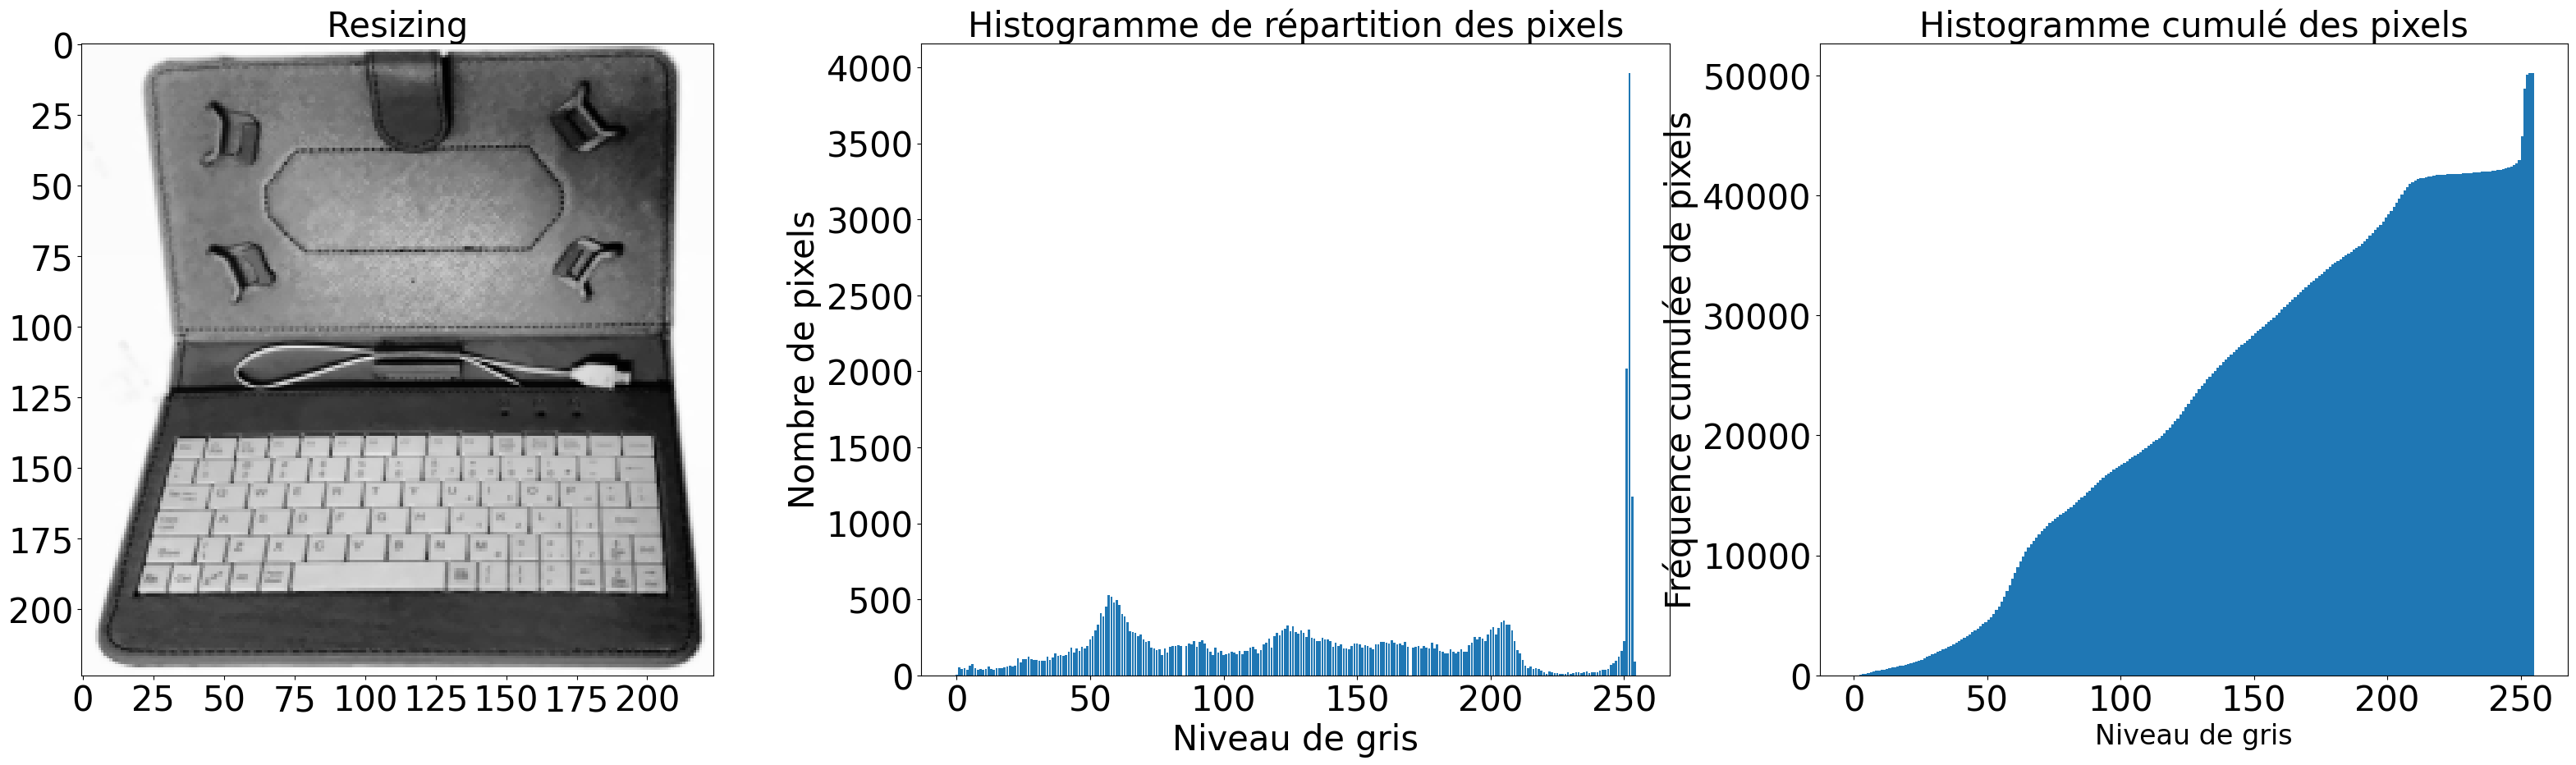

In [221]:
imgresiz = cv2.resize(np.array(imgden), (224,224), interpolation=cv2.INTER_AREA)
afficher_image_histopixel(imgresiz,' Resizing ')

In [115]:
# Pré-traitement de toutes les images
df['image_proces'] = \
    df['image_path'].apply(preprocess_image)

C:\Users\imen2\anaconda3\envs\oc_env\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


# 3.Extraction des features avec SIFT <a class="anchor" id="sift"></a>

**Etape1:Chargement des images prétraitées**

In [118]:
def charger_image_repertoire(repertoire):
    # Chargement des images pré-traitées
    images = {}
    for filename in os.listdir(repertoire):
        path = repertoire + "/" + filename
        img = cv2.imread(path, 0)
        images[filename] = img
    return images

In [176]:
# Chargement des images pré-traitées dans le dictionnaire images
dico_images = charger_image_repertoire('Flipkart/Images_process/')
print(f'{len(dico_images)} images chargées')

1050 images chargées


**Etape2: Extraction des features_visual words**

In [177]:
def sift_extract_features1(images):
    '''
    Extraire les descripteurs et keypoints(feature) avec SIFT.
    Parameters
    ----------
    images : les images dont on veut extraire les descripteurs et centres
             d'intérêt, obligatoire.
    Returns
    -------
    list des descripteurs et des vecteurs SIFT.
    '''
    sift_vectors = {}
    descriptor_list = []
    
    #sift = cv2.xfeatures2d.SIFT_create() 
    #The xfeatures2d don't belong to cv2 we replace it with cv2.SIFT_create()
    sift=cv2.SIFT_create()
    for key, value in images.items():
        features = []
        #image8bit = cv2.normalize(value, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        
        #value = cv2.cvtColor(value, cv2.COLOR_BGR2GRAY)
        try:
            kp, des = sift.detectAndCompute(value, None)
        except :
            print('key:',key)
            print('value:',value)
        descriptor_list.extend(des)
        # in case no descriptor
        des = [np.zeros((128,))] if des is None else des
        features.append(des)
        sift_vectors[key] = features
    return [descriptor_list, sift_vectors]


In [178]:
sifts = sift_extract_features1(dico_images)


In [179]:
# Liste des descripteurs = tous les 'visual words' de toutes les images
sift_list_descripteurs = sifts[0]
len(sift_list_descripteurs)

334132

In [180]:
# Liste des vecteurs(features) par images (dictionnaires clé=nom_image, vecteur)
sift_all_bovw_features = sifts[1]
len(sift_all_bovw_features)

1050

In [181]:
# Sauvegarde des descripteurs SIFT
with open('sauvegarde/sift_list_descripteurs.pickle', 'wb') as f:
    pickle.dump(sift_list_descripteurs, f, pickle.HIGHEST_PROTOCOL)
# Sauvegarde des vecteurs (features) par images SIFT
with open('sauvegarde/sift_all_bovw_features.pickle', 'wb') as f:
    pickle.dump(sift_all_bovw_features, f, pickle.HIGHEST_PROTOCOL)

**Etape3:Trouver les Bags of Visual Words (BOVW )**

-  il suffit d'appliquer un algorithme de clustering aux descripteurs de features construits à l'étape 2, comme le k-means. 
- Les visual words correspondent alors aux centres des clusters trouvés.

In [183]:
# Constitution de bag of visual words
sift_kmeans = cluster.KMeans(n_clusters=1000, n_init=10)
sift_kmeans.fit(sift_list_descripteurs)
sift_visual_words = sift_kmeans.cluster_centers_

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


In [185]:
# Sauvegarde du modèle KMeans Sift
with open('sauvegarde/sift_kmeans.pickle', 'wb') as f:
    pickle.dump(sift_kmeans, f, pickle.HIGHEST_PROTOCOL)
# Sauvegarde des VW SIFT
with open('sauvegarde/sift_visual_words.pickle', 'wb') as f:
    pickle.dump(sift_visual_words, f, pickle.HIGHEST_PROTOCOL)

**ÉTAPE 4 - Construction de l'histogramme pour chaque image** 
- Pour chaque image, on crée un histogramme qui indique la fréquence d'apparition de chaque visual word dans l'image :

In [191]:

def find_index(image, center):
    '''
    Find the index of the closest central point to the each sift descriptor.
    Paramètres: 
     image: sif descriptor 
     center:array of central points in k means
     Returns:
    the index of the closest central point.
    '''
    count = 0
    ind = 0
    for i in range(len(center)):
        if(i == 0):
            count = distance.euclidean(image, center[i])
            #count = L1_dist(image, center[i])
        else:
            dist = distance.euclidean(image, center[i])
            #dist = L1_dist(image, center[i])
            if(dist < count):
                ind = i
                count = dist
    return ind
def image_class(all_bovw, centers):
    dict_feature = {}
    for key, value in all_bovw.items():
        # display(key)
        category = []
        for img in value:
            # display(img)
            histogram = np.zeros(len(centers))
            for each_feature in img:
                ind = find_index(each_feature, centers)
                histogram[ind] += 1
            category.append(histogram)
        dict_feature[key] = category
    return dict_feature

In [192]:
sift_bovw =image_class(sift_all_bovw_features,
                                      sift_visual_words)

In [194]:
# Sauvegarde des BOVW SIFT
with open('sauvegarde/sift_bovw.pickle', 'wb') as f:
    pickle.dump(sift_bovw, f, pickle.HIGHEST_PROTOCOL)

In [195]:
def constituer_dataframe_vectors(dataframe, variable):
    '''
    Transformer les np.array des histogrammes en autant de colonnes pour
    être utilisable par TSNE et le clustering.
    Parameters
    ----------
    dataframe : dataframe des histogrammes des images.
    variable : nom de la variable contenant les histogrammes à extraire.
    Returns
    -------
    dataframe_vecteurs : le dataframe avec chacune des BOVW de chaque umage
    dans une colonne.
    '''
    vectors = np.column_stack(dataframe[variable].values.tolist())
    dataframe_vecteurs = pd.DataFrame(vectors).T

    return dataframe_vecteurs

In [197]:
# Dataframe de sauvegarde des BOVW SIFT
df_sift_bovw = pd.DataFrame({'image': sift_bovw.keys(),
                             'sift_bovw': sift_bovw.values()})
# Ajout des BOVW en np.array d'une liste
df_sift_bovw['Histo'] = [row[0] for row in df_sift_bovw['sift_bovw']]
# Ajout de la catégorie
df_sift_bovw = df_sift_bovw.merge(df[['image', 'image_path',
                                        'main_category']], how='left',
                                  on='image')
# Constituer le dataframe de vecteurs de BOVW
df_sift_vectors =constituer_dataframe_vectors(df_sift_bovw, 'Histo')

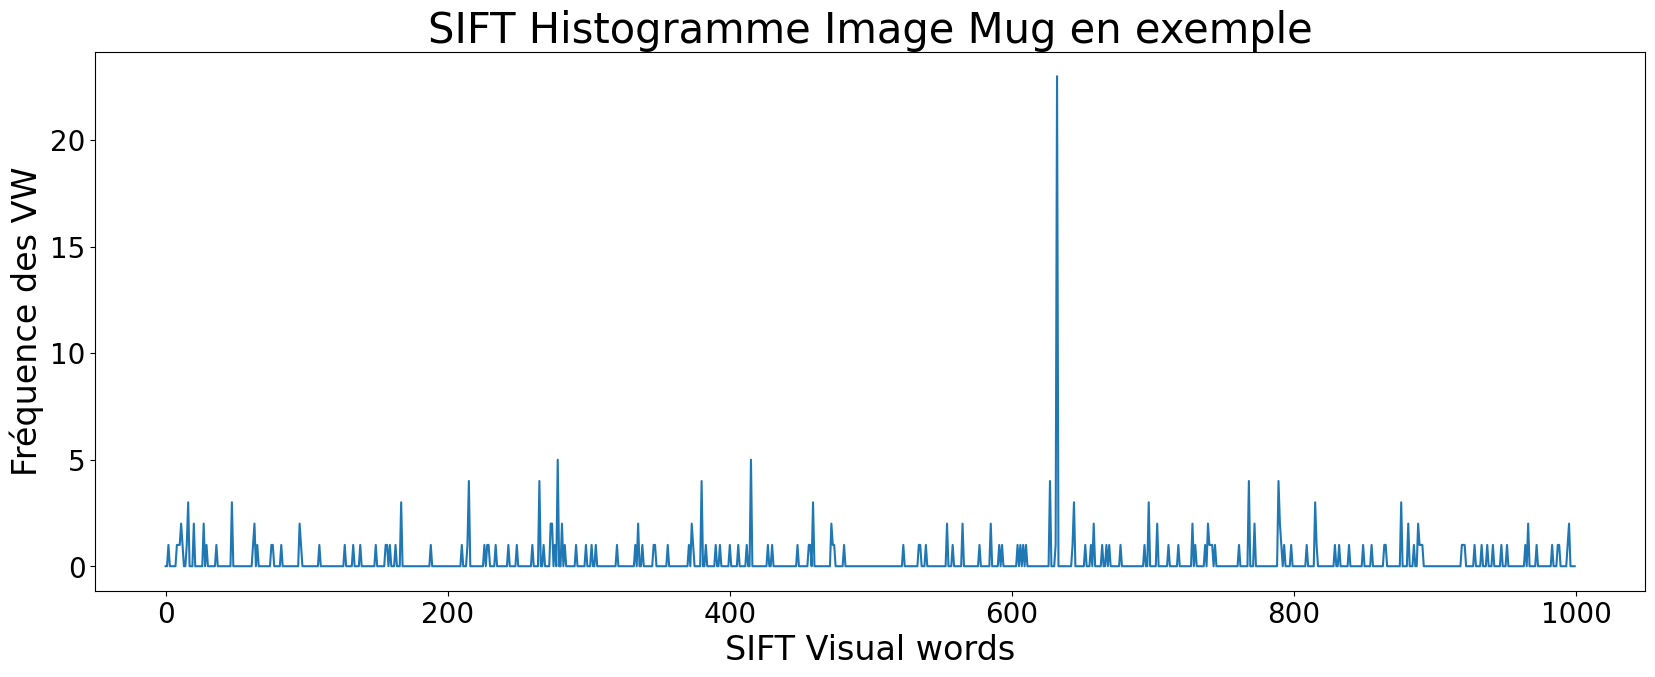

In [198]:
# Visualisation de l'histogramme pour notre image exemple
# Récupération de l'historgramme
df_visu = df_sift_bovw[df_sift_bovw['image'] ==
                       '00e966a5049a262cfc72e6bbf68b80e7.jpg']['sift_bovw']
histo_mug = df_visu.to_list()[0][0]
plt.figure(figsize=(20, 7))
plt.title('SIFT Histogramme Image Mug en exemple', fontsize=30)
plt.xlabel("SIFT Visual words", fontsize=24)
plt.ylabel("Fréquence des VW", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(False)
plt.plot(histo_mug)
plt.show()

**ÉTAPE 5 - Réduction de dimension des features et clustering des composantes réduites**  
- TSNe afin de réduire à 2 composantes les features 
- afficher les 2 composantes tsne en coloriant selon la catégorie réelle
- clustering kmeans à partir des deux coposantes
- afficher les 2 composantes tsne en coloriant selon le numéro de clusters Kmeans


In [222]:
l_cat = list(set(data['main_category']))
print("catégories : ", l_cat)

catégories :  ['Home Furnishing ', 'Beauty and Personal Care ', 'Watches ', 'Baby Care ', 'Computers ', 'Home Decor & Festive Needs ', 'Kitchen & Dining ']


In [223]:
#convert main_category (target) to int
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_cat_num = le.fit_transform(data['main_category'])
set(y_cat_num)

{0, 1, 2, 3, 4, 5, 6}

In [200]:
# Réduction de dimension tsne

# tsne_sift = manifold.TSNE(verbose=1, perplexity=30, n_iter=1000)
# X_proj_tsne_sift = \
#     tsne_sift.fit_transform(df_sift_vectors)
# # Dataframe pour clustering
# df_tsne_sift = pd.DataFrame({'VAR1' : X_proj_tsne_sift[:, 0],
#                              'VAR2' : X_proj_tsne_sift[:, 1],
#                              'CATEGORIE' : df_sift_bovw['main_category'],
#                              'IMAGE': df_sift_bovw['image'],
#                              'IMAGE_PATH': df_sift_bovw['image_path']})

C:\Users\imen2\anaconda3\envs\oc_env\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\imen2\anaconda3\envs\oc_env\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.016s...
[t-SNE] Computed neighbors for 1050 samples in 0.181s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 4.224700
[t-SNE] KL divergence after 250 iterations with early exaggeration: 118.814735
[t-SNE] KL divergence after 1000 iterations: 2.205967


In [204]:
cols = ['VAR1', 'VAR2']

In [205]:
# Instanciation du modèle KMeans 
# kmeans_tsne_sift = cluster.KMeans(n_clusters=7, init='k-means++',
#                           n_init=100, max_iter=300,
#                           random_state=42) \
#     .fit(df_tsne_sift[cols])
# # Ajout de l'assignation du cluster au dataframe
# df_tsne_sift['Clusters'] = kmeans_tsne_sift.labels_
# kmeans_tsne_sift_labels = kmeans_tsne_sift.labels_
# ARI = np.round(metrics.adjusted_rand_score(y_cat_num, kmeans_tsne_sift_labels),4)

# print("ARI : ", ARI)

In [210]:
import time

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    print('size',features.shape)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=1000, 
                                 )
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Catégorie principale")
    plt.title('Représentation des produits par  catégories principales réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des produits par clusters')
    
    plt.show()
    print("ARI : ", ARI)

In [211]:
ARI, X_tsne, labels = ARI_fct(df_sift_vectors)

size (1050, 1000)


C:\Users\imen2\anaconda3\envs\oc_env\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\imen2\anaconda3\envs\oc_env\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


ARI :  0.0017 time :  8.0


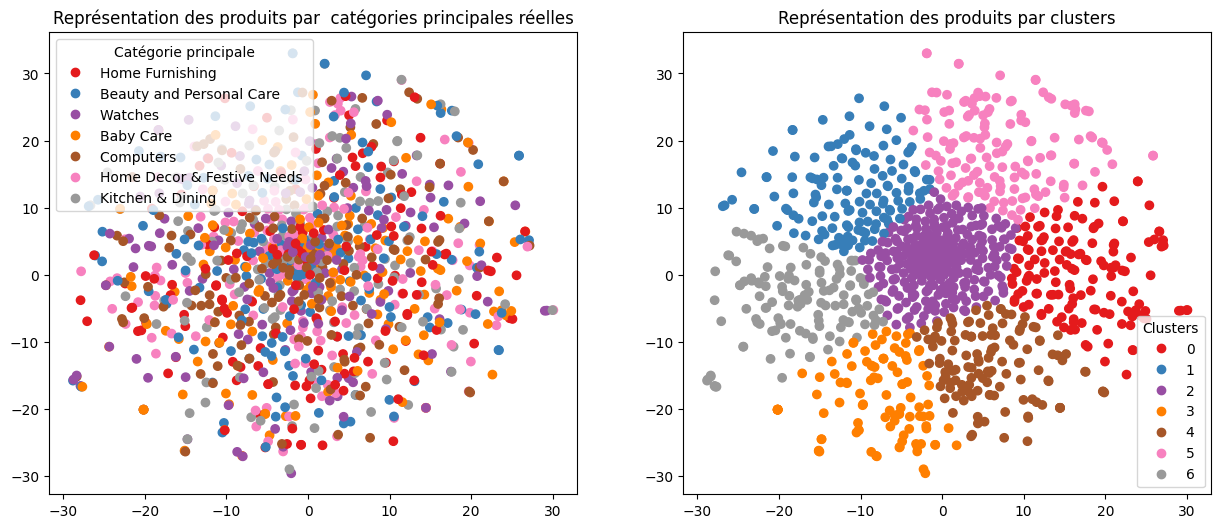

ARI :  0.0017


In [212]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

**Observations** :
***
- Le score ARI est faible (0.0017).
- Cette combinaison TSNE SIFT sur les images ne parvient pas à retrouver les 7 catégories comme le souhaite notre client 


# 4.Extraction des features avec Transfer learning<a class="anchor" id="tl"></a>

In [57]:
from keras.applications.efficientnet import EfficientNetB0
from keras.applications.efficientnet import preprocess_input

In [71]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

#load model without classifier layers
effnetb0 = EfficientNetB0(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
effnetb0.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_6 (Rescaling)        (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization_3 (Normalization  (None, 224, 224, 3)  7          ['rescaling_6[0][0]']            
 )                                                                                                
                                                                                     

                                                                                                  
 block2a_project_conv (Conv2D)  (None, 56, 56, 24)   2304        ['block2a_se_excite[0][0]']      
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block3b_expand_bn (BatchNormal  (None, 28, 28, 240)  960        ['block3b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_b

 block4b_dwconv (DepthwiseConv2  (None, 14, 14, 480)  4320       ['block4b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePoolin

                                                                                                  
 block5a_activation (Activation  (None, 14, 14, 480)  0          ['block5a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
          

                                                                                                  
 block5c_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5c_se_reduce[0][0]']      
                                                                                                  
 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block6b_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
          

                                                                                                  
 block6d_add (Add)              (None, 7, 7, 192)    0           ['block6d_drop[0][0]',           
                                                                  'block6c_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation) 

In [72]:
features2 = model.predict(data_array_cnn2)

33/33 [==============================] - 26s 791ms/step


In [75]:
# Dataframe de sauvegarde des BOVW effin0
# Association des features à chaque image
data['effnetb0_bovw'] = [effnetb0_all_features[i] for i in range(data.shape[0])]
# Dataframe de travail
df_effnetb0_bovw = data[['image', 'image_path', 'main_category', 'effnetb0_bovw']]
# Constituer le dataframe de vecteurs de BOVW effin0
df_effnetb0_vectors = pd.DataFrame.from_records(effnetb0_all_features)

In [69]:
data.columns

Index(['description', 'product_name', 'image', 'main_category',
       'description_bow', 'description_bow_lem_stem', 'description_dl',
       'pdtname_bow', 'pdtname_bow_lem_stem', 'pdtname_dl', 'image_path'],
      dtype='object')

In [79]:
# Sauvegarde du dataframe des vectors BOVW VGG19
with open('sauvegarde/df_effnetb0_vectors.pickle', 'wb') as f:
    pickle.dump(df_effnetb0_vectors, f, pickle.HIGHEST_PROTOCOL)

catégories :  ['Home Furnishing ', 'Beauty and Personal Care ', 'Watches ', 'Baby Care ', 'Computers ', 'Home Decor & Festive Needs ', 'Kitchen & Dining ']


{0, 1, 2, 3, 4, 5, 6}

In [89]:
print(" feature extraction using transfer learning : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(df_effnetb0_vectors)

 feature extraction using transfer learning : 
-----------------
size (1050, 62720)
ARI :  0.3596 time :  14.0


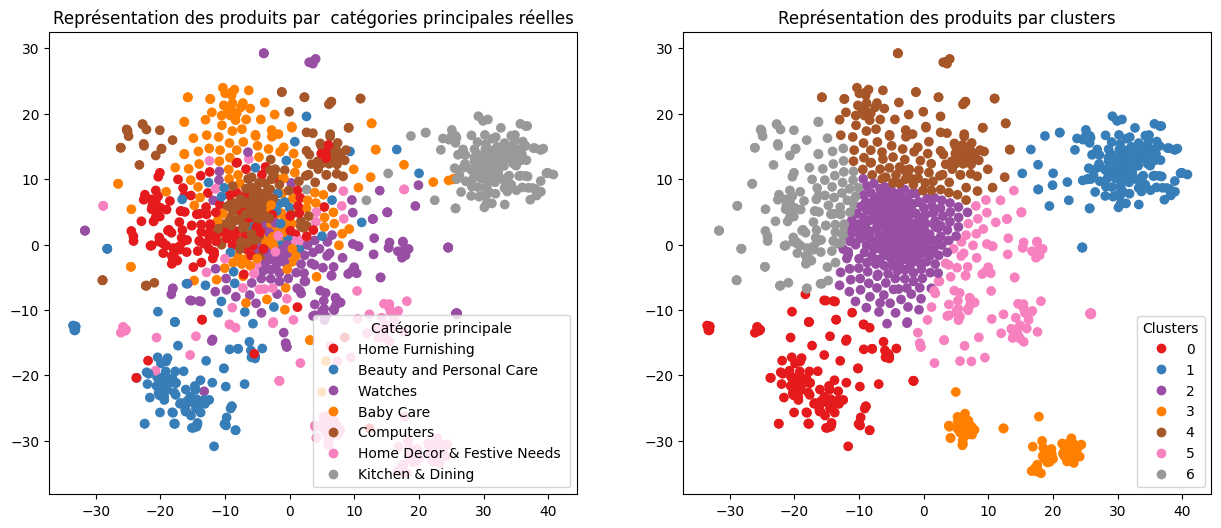

ARI :  0.3596


In [92]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)